# Housing Price Prediction
**[Johnny Yiu](https://github.com/johnnyyiu)**

<a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques"><img src="https://i.imgur.com/C0qJ5Kv.jpg" title="
House Prices: Advanced Regression Techniques" /></a>

## Goal
The goal is to predict the sales price for each house. With 79 explanatory variables describing almost every aspect of residential homes in Ames, Iowa, we hope to accurately predict the sales price with creative feature engineering and advanced regression techniques.

## Data
The Ames Housing dataset was compiled by [Dean De Cock](http://jse.amstat.org/v19n3/decock.pdf), which is an alternative to the often cited Boston Housing dataset. 

## Model
We evaluate the performance of 9 different models (lasso, elasticnet, ridge, svr, gradient boosting, random forest, xgboost, lightgbm, catboost regressors) by their Root-Mean-Squared-Error (RMSE) using a 10-fold cross validation. We then trained a meta StackingCVRegressor with 8 of the models (excluding random forest) and optimized using lasso. The final prediction will be an ensembled predictions from the models to prevent overfitting. Our final score is a good RMSE of **0.11525**.

## Inspiration
* [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

* [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition)

* [#1 House Prices Solution [top 1%]](https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1)

## Import the libraries

In [0]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Featuretools
from sklearn import feature_selection as fs
import featuretools as ft

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
# print(os.listdir("../input/kernel-files"))

## Import the data

In [2]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Housing/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Housing/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [3]:
# Preview the data we're working with
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Label: SalePrice

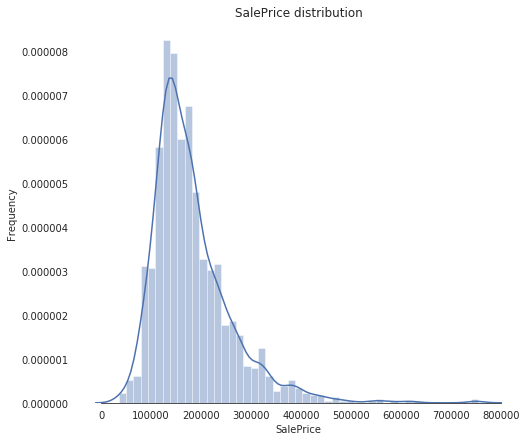

In [4]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [5]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


We see that the distribution of SalePrice is positively skewed.

## Features: a deep dive

Visualizing some of the features in the dataset:

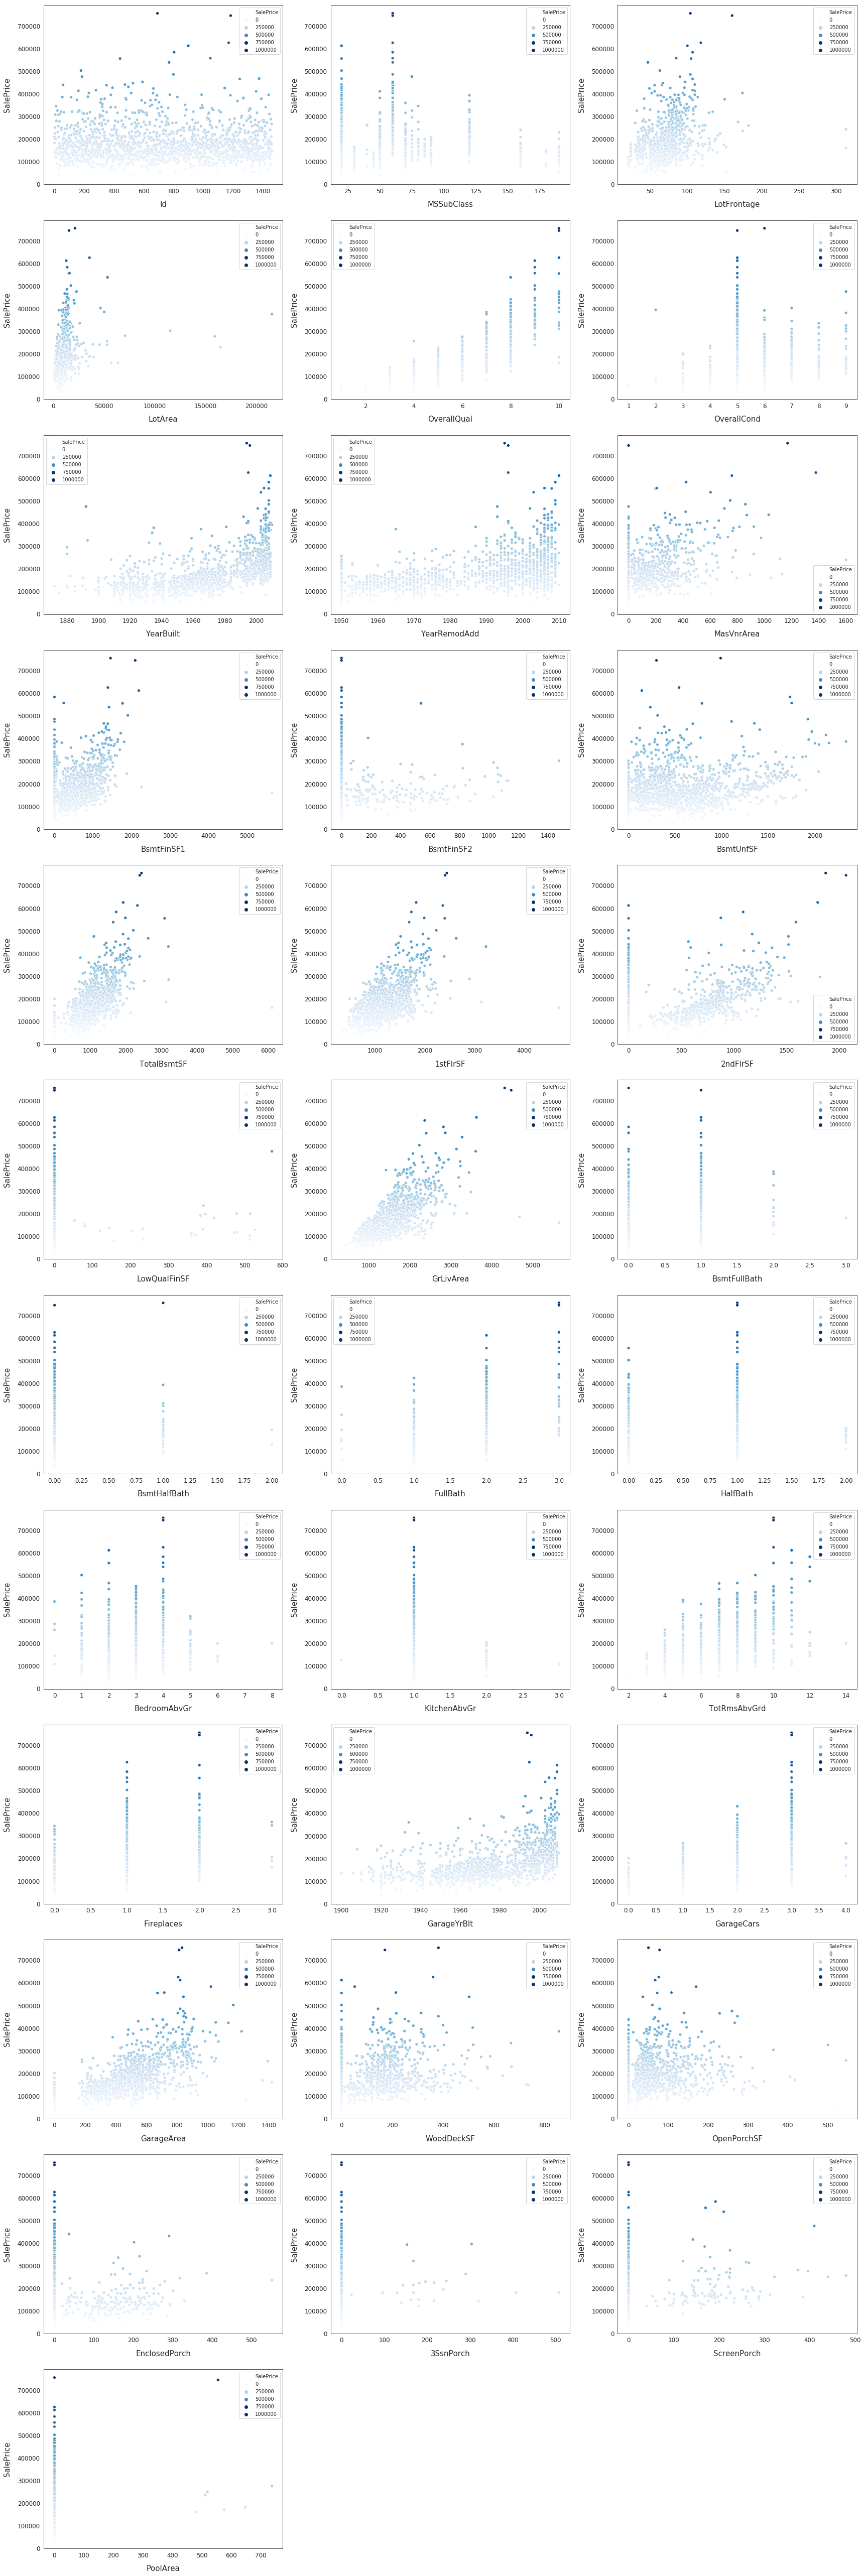

In [6]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

Correlation heatmap of features:

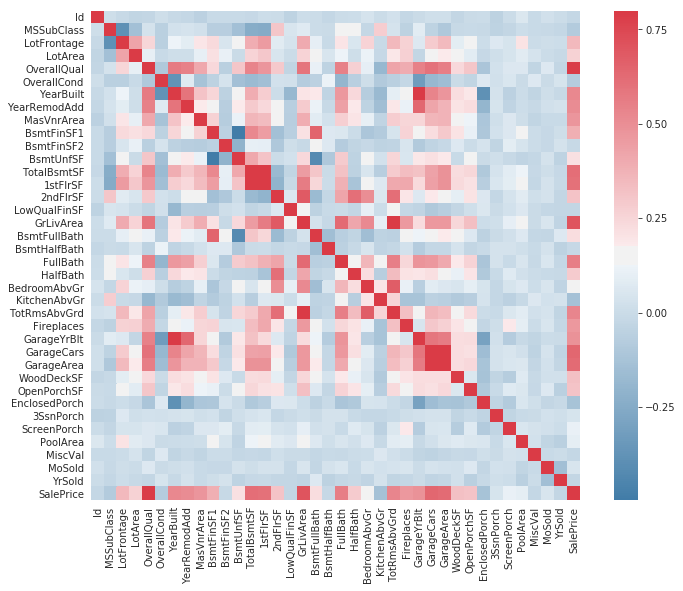

In [7]:
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, 
            cmap = sns.diverging_palette(240, 10, as_cmap = True), 
            vmax=.8, square=True)

Zoom in on the features most correlated with SalePrice:

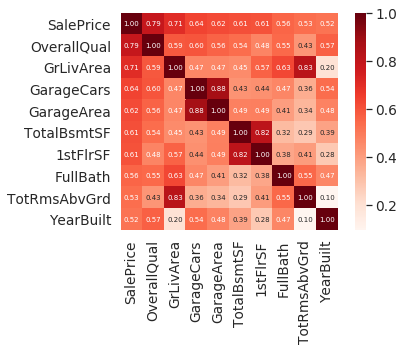

In [8]:
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, 
                 cmap = 'Reds', 
                 cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's check out the distributions of these features, and their relations with each other:

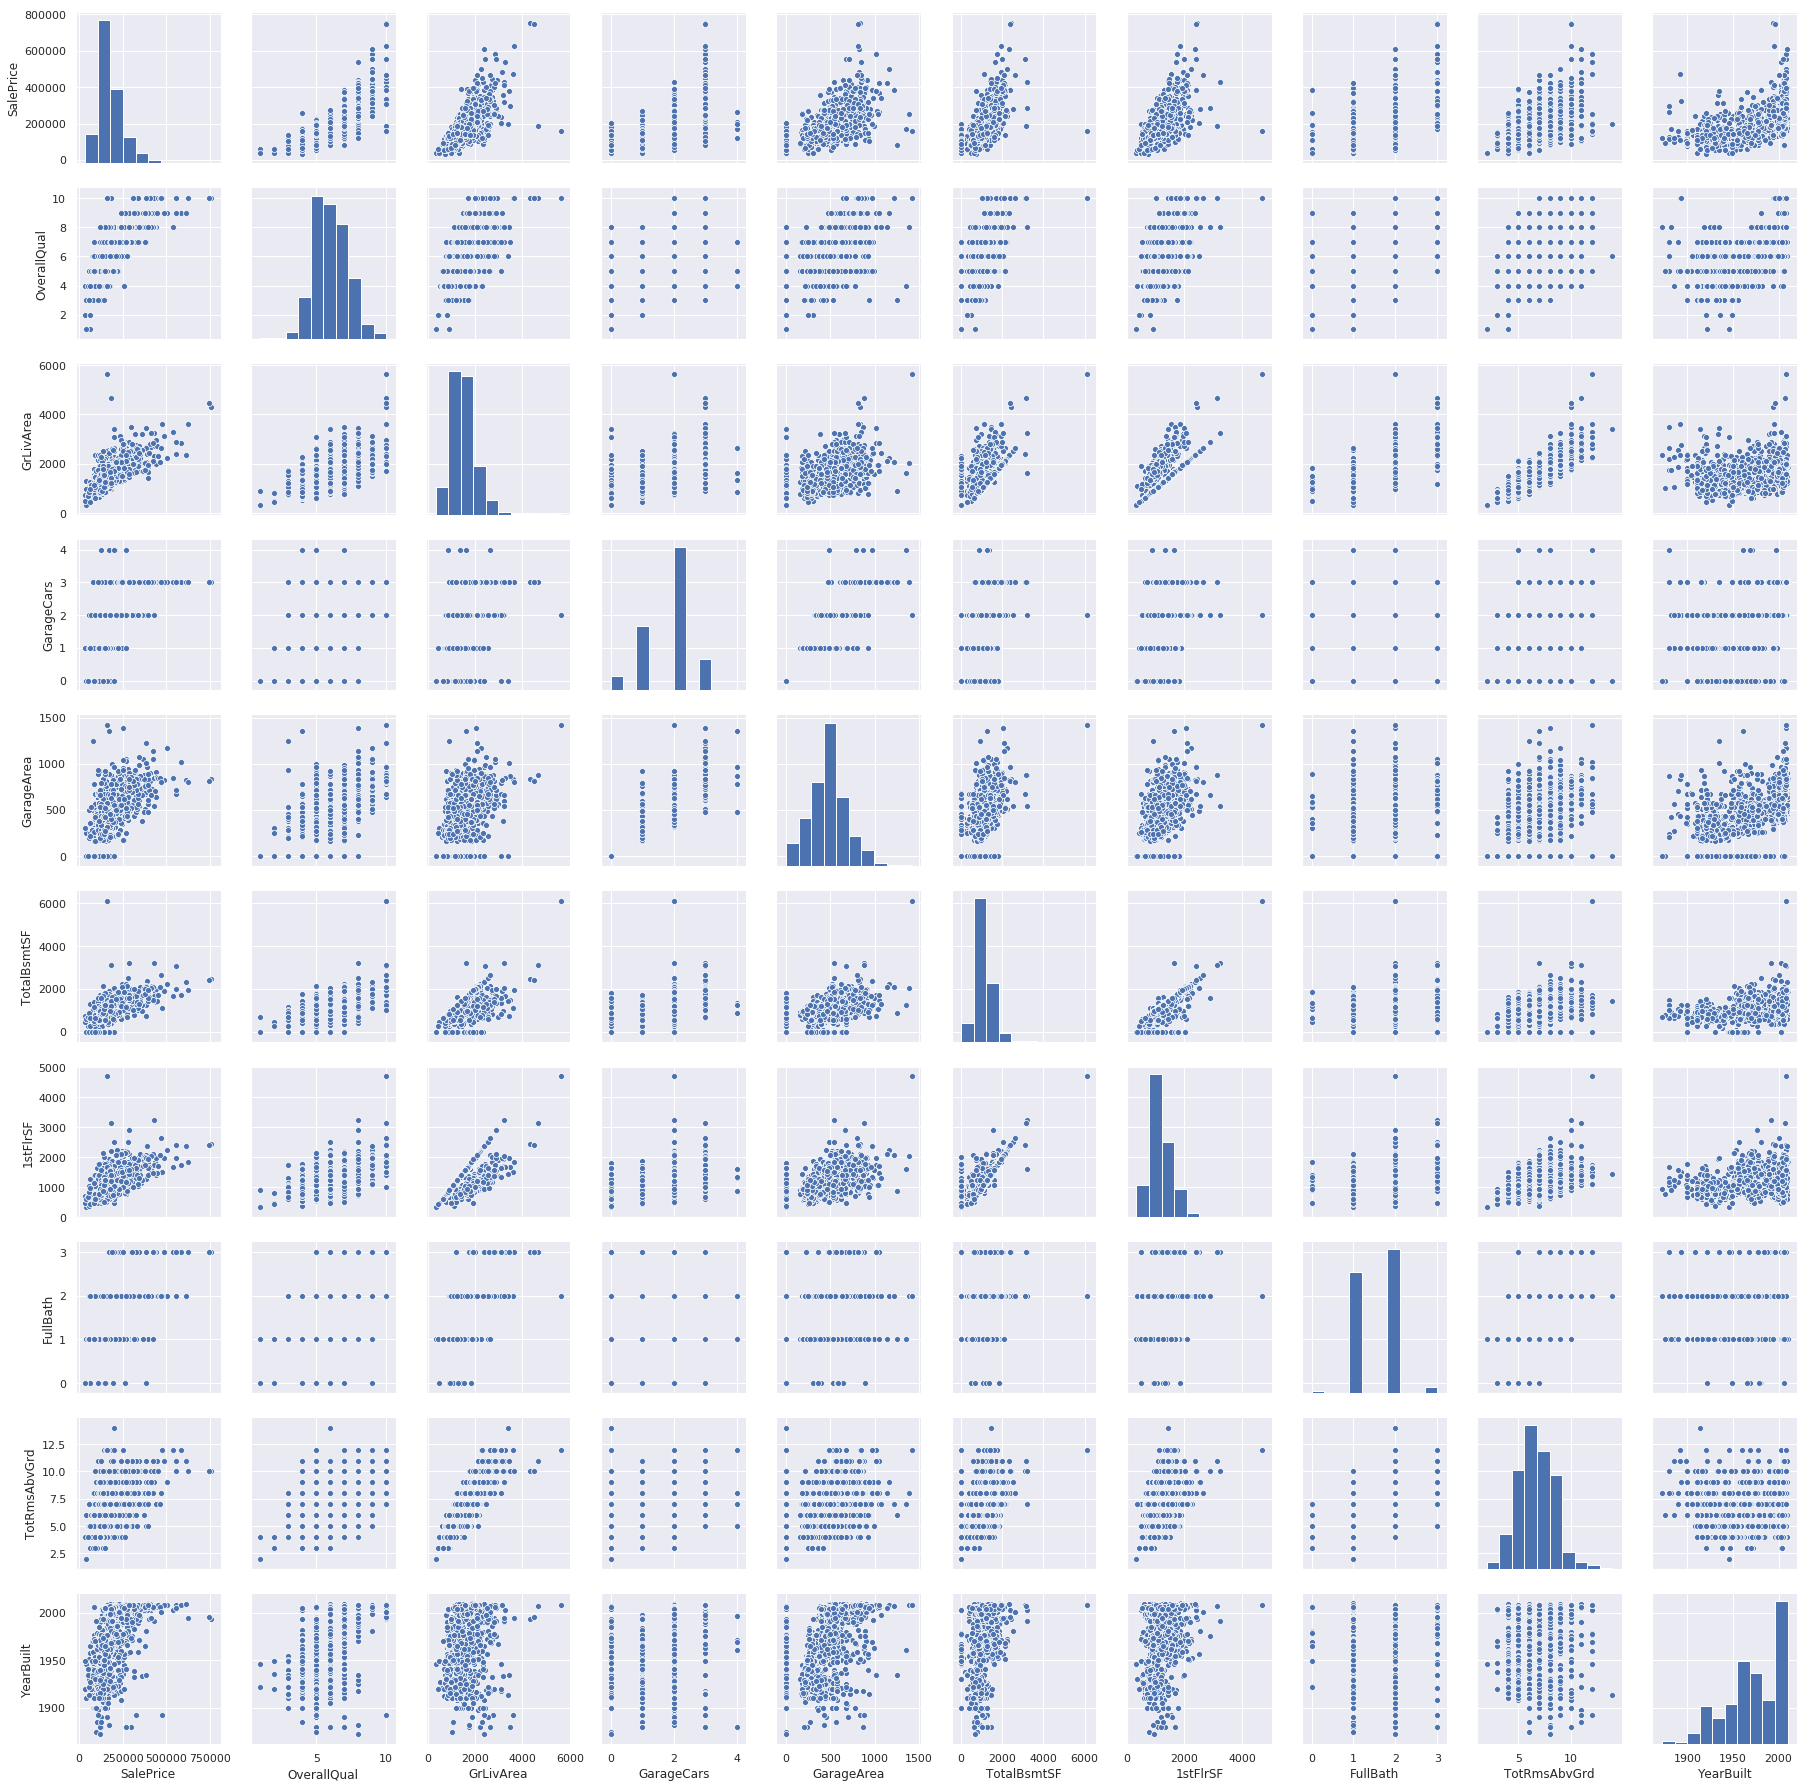

In [9]:
sns.set()
cols = corr.nlargest(10, 'SalePrice')['SalePrice'].index
cols = cols.tolist()
sns.pairplot(train[cols], size = 2.5)
plt.show();

SalePrice vs some categorical features:

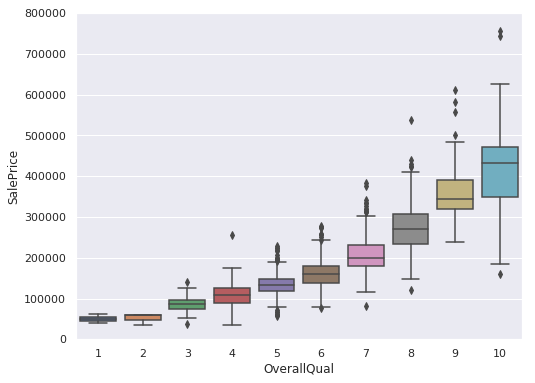

In [10]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

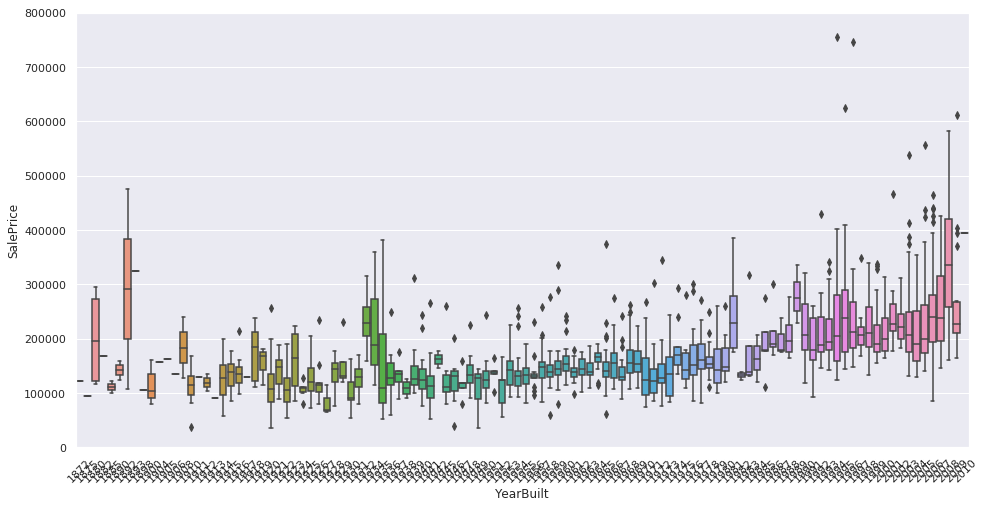

In [11]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);

SalePrice vs some numeric features:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


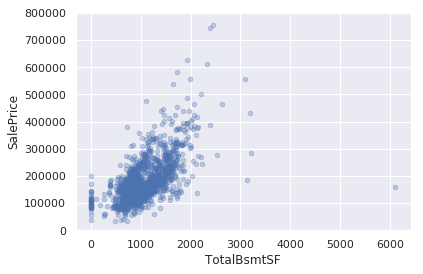

In [12]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


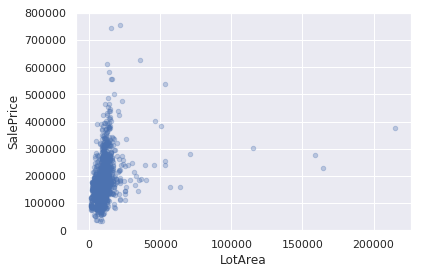

In [13]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


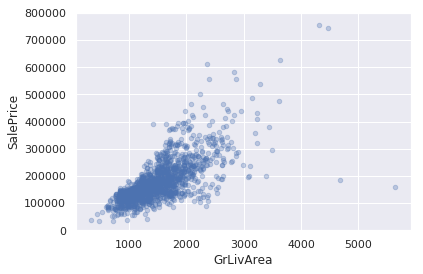

In [14]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

In [15]:
# Removing the Ids from train and test set which are not useful to our model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

# Feature Engineering

Let's recap the distribution of SalePrice:

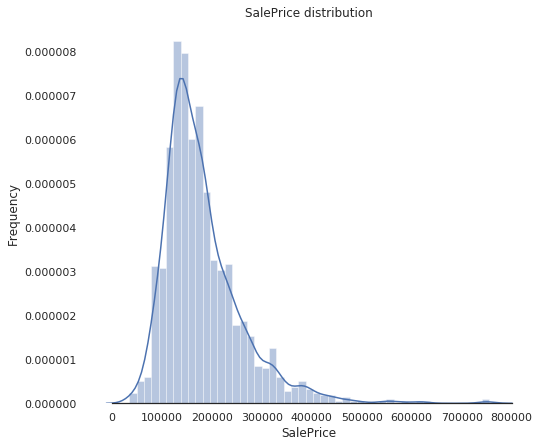

In [16]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

We will apply a log(1+x) tranform to fix the skew

In [0]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Plotting the transformed SalePrice:


 mu = 12.02 and sigma = 0.40



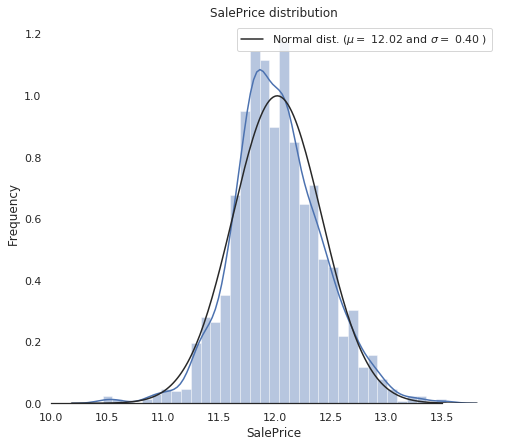

In [18]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [0]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [20]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

## Fill missing values

Lets visualize missing values in our combined data set:

In [21]:
missing = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
missing_data.head(20)

,Missing,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


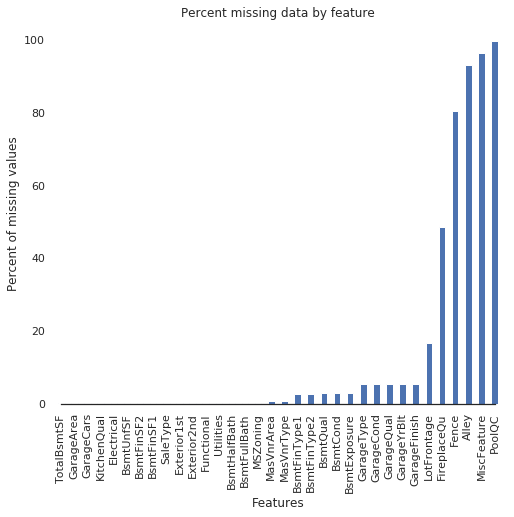

In [22]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(all_features.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

Next, we impute missing values 

In [0]:
# Convert some categorical features to string data, which were falsely represented as numerical
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [0]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [25]:
# Let's make sure we handled all the missing values
missing = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
missing_data.head(20)

,Missing,Percent
SaleCondition,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
BsmtQual,0,0.0


There are no missing values anymore.

## Fix skewed features

Let's first fetch all numeric features and visualize their distributions:

In [0]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

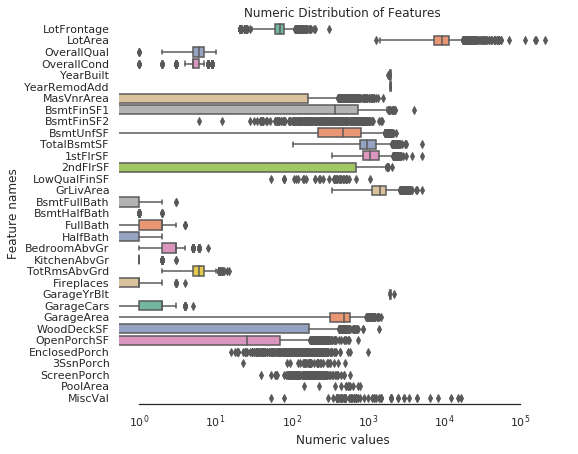

In [27]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set2")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

Then, we calculate their skewness and normalize and highly skewed ones

In [28]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

Normalizing skewed data with the Box-Cox transformation

In [0]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

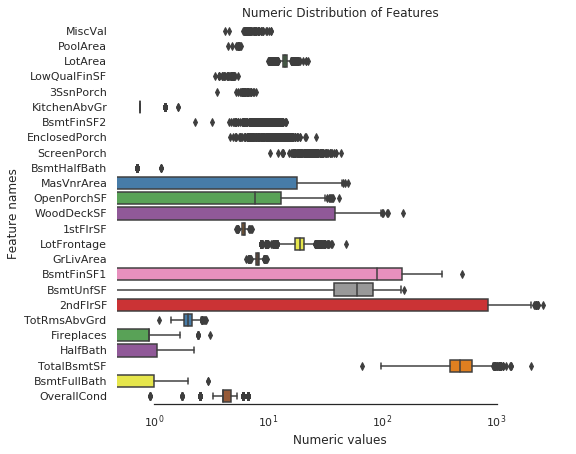

In [30]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## Create interesting features

We create new features based on our intuition and knowledge of the dataset:

In [0]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Feature transformations
Create more features by log and square transforming the original features

In [0]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [0]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encode categorical features

Next, we have to get dummy variables for categorical features:

In [34]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [35]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po

In [36]:
all_features.shape

(2917, 379)

In [0]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Remove Collinear Features

To prevent collinearity, we remove features with correlation greater than 0.99

In [38]:
corr_matrix = all_features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('There are {} columns with >= 0.99 correlation.'.format(len(to_drop)))
to_drop

There are 38 columns with >= 0.99 correlation.


['Has3SsnPorch',
 'YearsSinceRemodel',
 'haspool',
 'hasgarage',
 'LotArea_log',
 'BsmtFinSF2_log',
 '1stFlrSF_log',
 '2ndFlrSF_log',
 'LowQualFinSF_log',
 'GrLivArea_log',
 'BsmtFullBath_log',
 'BsmtHalfBath_log',
 'FullBath_log',
 'HalfBath_log',
 'KitchenAbvGr_log',
 'TotRmsAbvGrd_log',
 'Fireplaces_log',
 'EnclosedPorch_log',
 '3SsnPorch_log',
 'ScreenPorch_log',
 'PoolArea_log',
 'MiscVal_log',
 'YearRemodAdd_log',
 'YearRemodAdd_sq',
 'LotFrontage_log_sq',
 '1stFlrSF_log_sq',
 '2ndFlrSF_log_sq',
 'GrLivArea_log_sq',
 'GarageCars_log_sq',
 'BldgType_Duplex',
 'BsmtFinType1_None',
 'BsmtFinType2_None',
 'CentralAir_Y',
 'FireplaceQu_None',
 'GarageType_None',
 'GarageFinish_None',
 'GarageQual_None',
 'GarageCond_None']

In [39]:
all_features = all_features[[x for x in all_features if x not in to_drop]]
all_features.shape

(2917, 340)

## Variance-based Feature Selection

Features with dominating values are not very helpful to our model, we remove features that has a variance lower than 0.99*(1-0.99)

In [40]:
sel = fs.VarianceThreshold(threshold=(.99 * (1 - .99)))
all_features = sel.fit_transform(all_features)
print(sel.get_support())
print(all_features.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True  True False False  True  True  True
 False  True  True  True False  True False  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True False
  True  True  True False False False  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True False  True  True  True False  True False  True
 False False False False False False False False False False  True  True
  True  True  True False  True False False  True  True  True False  True
 False  True False False  True False False False Fa

## Recreate training and test sets

In [41]:
all_features = pd.DataFrame(all_features)
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 253), (1458,), (1459, 253))

## Recursive Feature Elimination

We use RFE to select the most important features

In [42]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
l2 = Ridge()
rfecv = fs.RFECV(estimator = l2, cv = kf,
                      scoring = 'neg_mean_squared_error')
rfecv.fit(X, train_labels)
print(rfecv.support_)
print(rfecv.ranking_)

X = rfecv.transform(X)
X_test = rfecv.transform(X_test)

print(X.shape)
print(X_test.shape)

[ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [0]:
X = pd.DataFrame(X)
X_test = pd.DataFrame(X_test)

# Train models

## Define cross validation and error metrics

In [0]:
# Setup cross validation folds
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [0]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Create models

In [46]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1)
# Lasso
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(), 
                      LassoCV(max_iter=1e7, 
                              alphas=alphas2, 
                              random_state=42, 
                              cv=kf))

#ElasticNet
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, 
                                        alphas=e_alphas, 
                                        cv=kf, 
                                        l1_ratio=e_l1ratio))

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# Ridge Regressor
ridge_alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators = 5000,
                           max_depth = 17, 
                           min_samples_split = 2,
                           min_samples_leaf = 2,
                          max_features='sqrt',
                          oob_score=True,
                          random_state=42)

# Catboost Regressor
!pip install catboost
from catboost import CatBoostRegressor
catbr = CatBoostRegressor(iterations = 5000, 
                          depth = 3, 
                          bagging_temperature = 0.8,
                          learning_rate = 0.01,
                          eval_metric='RMSE',
                          task_type = 'GPU', 
                          silent = True,
                             random_seed = 42)





# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            svr, gbr, xgboost, lightgbm, catbr),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

     |████████████████████████████████| 62.5MB 638kB/s 


## Grid Search

Using grid search to iteratively tune model parameters, the end results are shown above

In [0]:
# param_grid = {'bagging_temperature': [0.2, 0.5, 0.8]
#              }
# gsearch = GridSearchCV(estimator = catbr, param_grid = param_grid, 
#                       cv = kf,
#                       scoring = 'neg_mean_squared_error',
#                       return_train_score = True)
# gsearch.fit(X, train_labels)
# gsearch.best_params_, gsearch.best_score_

## Train models

### Get cross validation scores for each model

In [0]:
scores = {}

In [49]:
score = cv_rmse(catbr)
print("catbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['catbr'] = (score.mean(), score.std())

catbr: 0.1175 (0.0153)


In [50]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1145 (0.0160)


In [51]:
score = cv_rmse(lasso)
print("lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lasso'] = (score.mean(), score.std())

lasso: 0.1097 (0.0166)


In [52]:
score = cv_rmse(elasticnet)
print("elasticnet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['elasticnet'] = (score.mean(), score.std())

elasticnet: 0.1097 (0.0165)


In [53]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1157 (0.0161)


In [54]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1085 (0.0177)


In [55]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1101 (0.0167)


In [56]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1358 (0.0146)


In [57]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1133 (0.0147)


### Fit the models

In [58]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen


In [59]:
print('catbr')
catbr_model_full_data = catbr.fit(X, train_labels)

catbr


In [60]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [61]:
print('lasso')
lasso_model_full_data = lasso.fit(X, train_labels)

lasso


In [62]:
print('elasticnet')
elasticnet_model_full_data = elasticnet.fit(X, train_labels)

elasticnet


In [63]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [64]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [65]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [66]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [67]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


## Ensemble models and get predictions

In [0]:
# Ensemble models in order to make the final predictions more robust to overfitting
def ensembled_predictions(X):
    return ((0.1 * elasticnet_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.05 * catbr_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [69]:
# Get final precitions from the ensembled model
ensembled_score = rmsle(train_labels, ensembled_predictions(X))
scores['ensembled'] = (ensembled_score, 0)
print('RMSLE score on train data:')
print(ensembled_score)

RMSLE score on train data:
0.08734670043453914


## Identify the best performing model

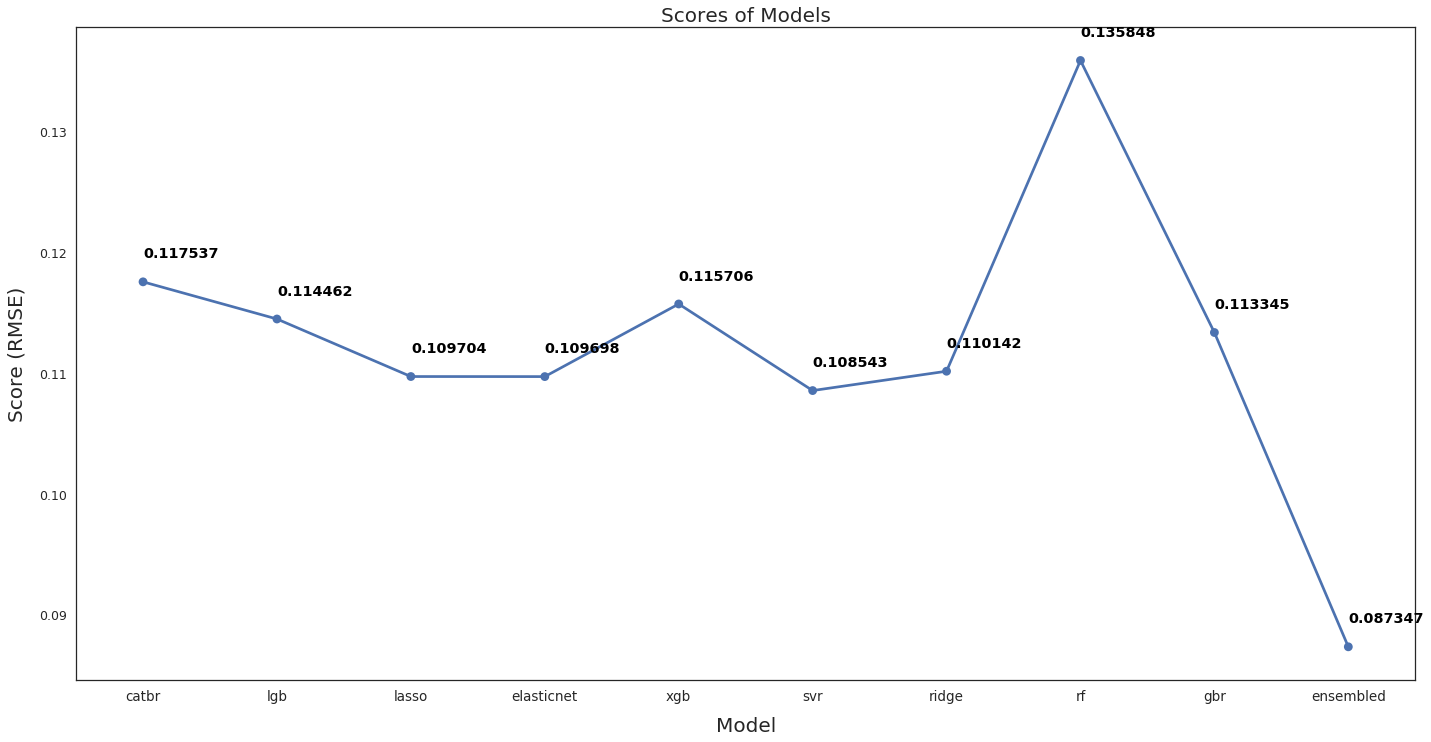

In [70]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## Submit predictions

In [71]:
# Read in sample_submission dataframe
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Housing/sample_submission.csv")
submission.shape

(1459, 2)

In [0]:
# Append predictions from ensembled models
submission.iloc[:,1] = np.floor(np.expm1(ensembled_predictions(X_test)))

In [0]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [0]:
# Scale predictions
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression.csv", index=False)